In [1]:
!pip install wandb

import os
from google.colab import files

# Upload the kaggle.json file
uploaded = files.upload()

# Make the necessary directories and move kaggle.json to the proper location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Set the environment variable for Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.2/289.2 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json


In [18]:

import os, glob, shutil
import urllib.request as r
import kaggle

def data_yuklab_olish(data_nomi = "lentils"):

    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", "apple_disease", "insects", "cars", "crop",
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac", "vehicles", "cloud", "skin_lesion", "fire"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"

    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    elif data_nomi == "apple_disease": url = "kaggle datasets download -d killa92/apple-disease-dataset"
    elif data_nomi == "vehicles": url = "kaggle datasets download -d killa92/vehicle-detection-dataset"
    elif data_nomi == "cloud": url = "kaggle datasets download -d killa92/cloud-quality-images-classification-dataset"
    elif data_nomi == "insects": url = "kaggle datasets download -d killa92/arthropodia-semantic-segmentation-dataset"
    elif data_nomi == "cars": url = "kaggle datasets download -d killa92/car-detect-dataset"
    elif data_nomi == "skin_lesion": url = "kaggle datasets download -d killa92/skin-lesion-image-ham-classification"
    elif data_nomi == "crop": url = "kaggle datasets download -d killa92/crop-disease-image-classification-dataset"
    elif data_nomi == "fire": url = "kaggle datasets download -d killa92/fire-segmentation-dataset"

    # Download from the checkpoint path
    if os.path.isfile(f"{data_nomi}.csv") or os.path.isdir(f"{data_nomi}"): print(f"Dataset yuklab olingan. {data_nomi} papkasini ni tekshiring."); pass

    # If the checkpoint does not exist
    else:
        ds_nomi = url.split("/")[-1]
        full_path = f"{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{ds_nomi}", f"{data_nomi}")
        print(f"Tanlangan dataset {data_nomi} papkasiga yuklab olindi!")

data_yuklab_olish( data_nomi = "fire")



fire dataset yuklanmoqda...
Tanlangan dataset fire papkasiga yuklab olindi!


Total dataset size: 38852
Training dataset size: 31081
Validation dataset size: 7771


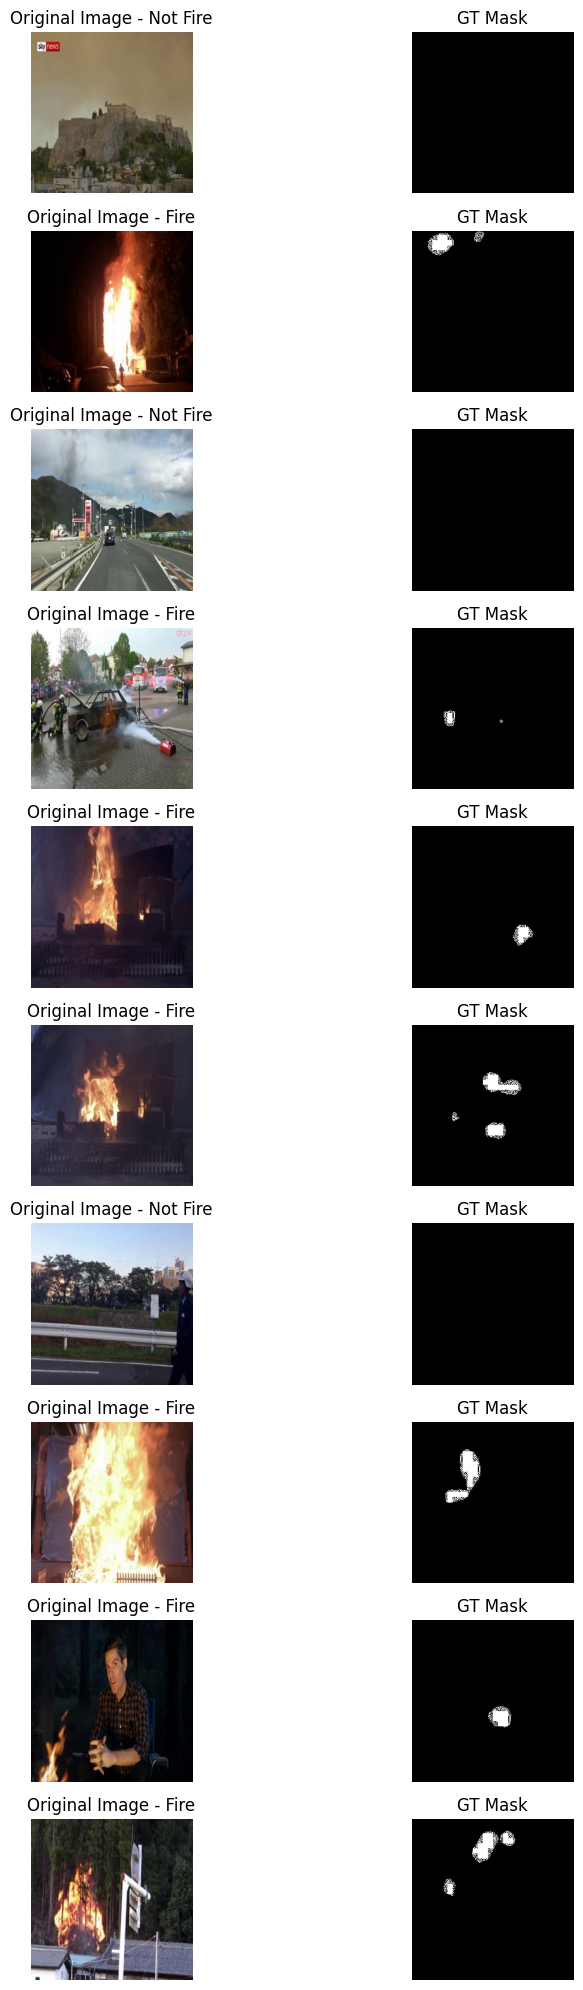

In [20]:
import os
from torch.nn import *
import shutil
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from glob import glob as glob_func
import numpy as np
# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Define paths for fire images and masks
        self.fire_image_dir = os.path.join(root_dir, 'fire', 'fire', 'images', 'fire')
        self.fire_mask_dir = os.path.join(root_dir, 'fire', 'fire', 'masks')

        # Define paths for not_fire images
        self.not_fire_image_dir = os.path.join(root_dir, 'fire', 'fire', 'images', 'not_fire')

        # Get lists of all images and masks
        self.fire_images = glob_func(os.path.join(self.fire_image_dir, '*.jpg'))
        self.fire_masks = sorted(glob_func(os.path.join(self.fire_mask_dir, '*.jpg')))
        self.not_fire_images = glob_func(os.path.join(self.not_fire_image_dir, '*.jpg'))

        # Combine lists and create labels
        self.images = self.fire_images + self.not_fire_images
        self.masks = self.fire_masks + [None] * len(self.not_fire_images)
        self.labels = [1] * len(self.fire_images) + [0] * len(self.not_fire_images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
     if torch.is_tensor(idx):
        idx = idx.tolist()

     img_name = self.images[idx]
     mask_name = self.masks[idx]
     label = self.labels[idx]

     image = Image.open(img_name).convert('RGB')
     if mask_name is not None:
         mask = Image.open(mask_name).convert('L')
     else:
        # Create an empty mask tensor
         mask = Image.new('L', image.size)  # Create a black (all zeros) mask of the same size as the image

     if self.transform:
         image = self.transform(image)
         mask = self.transform(mask)

     mask = torch.from_numpy(np.array(mask, dtype=np.int64))

     return image, mask, label



# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create an instance of the custom dataset
dataset = CustomDataset(root_dir='/content', transform=transform)

# Check the size of the dataset
dataset_size = len(dataset)
print(f"Total dataset size: {dataset_size}")

# Ensure dataset is not empty
if dataset_size > 0:
    # Splitting the dataset into training and validation sets
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size

    # Print the sizes of the splits
    print(f"Training dataset size: {train_size}")
    print(f"Validation dataset size: {val_size}")

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4)
else:
    raise ValueError("The dataset is empty!")

# Function to visualize random images and their masks
def visualize_random_images_and_masks(dataset, num_images=10):
    fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 2))

    indices = torch.randperm(len(dataset))[:num_images]

    for row, idx in enumerate(indices):
        img, mask, label = dataset[idx]
        img = img.permute(1, 2, 0)

        img = (img - img.min()) / (img.max() - img.min())

        title = "Fire" if label == 1 else "Not Fire"

        axs[row, 0].imshow(img.numpy())
        axs[row, 0].set_title(f"Original Image - {title}")
        axs[row, 0].axis('off')

        if mask is not None:
            mask = mask.squeeze()
            axs[row, 1].imshow(mask.numpy(), cmap='gray')
            axs[row, 1].set_title("GT Mask")
        else:
            axs[row, 1].text(0.5, 0.5, 'No Mask', horizontalalignment='center', verticalalignment='center', transform=axs[row, 1].transAxes, fontsize=12)
            axs[row, 1].set_title("GT Mask")

        axs[row, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display the plots
visualize_random_images_and_masks(dataset)


In [36]:
class Metrics:
    def __init__(self, pred, gt, loss_fn, n_cls):
        self.pred = pred
        self.gt = gt
        self.loss_fn = loss_fn
        self.n_cls = n_cls

    def loss(self):
        return self.loss_fn(self.pred, self.gt.squeeze(1).long())

    def PA(self):
        # Calculate and return the Pixel Accuracy
        pred_labels = torch.argmax(self.pred, dim=1)
        correct = pred_labels.eq(self.gt.squeeze(1)).sum().item()
        total = self.gt.nelement()
        return correct / total

    def mIoU(self):
        # Calculate and return the mean Intersection over Union
        pred_labels = torch.argmax(self.pred, dim=1)
        intersection = (pred_labels & self.gt.squeeze(1)).float().sum((1, 2))
        union = (pred_labels | self.gt.squeeze(1)).float().sum((1, 2))
        iou = intersection / (union + 1e-6)
        return iou.mean().item()

    def loss(self): return self.loss_fn(self.pred, self.gt.squeeze(1))

In [37]:
class UNetBlock(Module): # CustomDataset(torch.nn.Dataset); len, getitem

    def __init__(self, in_chs, out_chs, ks = 3, p = 1):
        super().__init__()
        self.ks, self.p = ks, p
        self.block_1 = self.get_conv_block(in_chs = in_chs, out_chs = out_chs)
        self.block_2 = self.get_conv_block(in_chs = out_chs, out_chs = out_chs)

    def get_conv_block(self, in_chs, out_chs):

        return Sequential(Conv2d(in_channels = in_chs, out_channels = out_chs, kernel_size = self.ks, padding = self.p),
                          BatchNorm2d(num_features = out_chs), ReLU(inplace = True))

    def forward(self, inp): return self.block_2(self.block_1(inp))

class DownSampling(Module):

    def __init__(self, in_chs, out_chs):
        super().__init__()

        self.downsample_block = Sequential(UNetBlock(in_chs = in_chs, out_chs = out_chs), MaxPool2d(kernel_size = 2, stride = 2))

    def forward(self, inp): return self.downsample_block(inp)


class UpSampling(Module):
    def __init__(self, in_chs, out_chs, mode, upsample = None):
        super().__init__()

        if mode in ["bilinear", "nearest"]: # else: tr_conv: upsample = None
            upsample = True
            up_mode = mode

        self.upsample = Upsample(scale_factor = 2, mode = up_mode) if upsample else ConvTranspose2d(in_channels = in_chs, out_channels = in_chs // 2, kernel_size = 2, stride = 2)
        self.conv = UNetBlock(in_chs = in_chs, out_chs = out_chs)

    def forward(self, inp1, inp2):

        inp1 = self.upsample(inp1) # im_dim is increased 2 times

        pad_y = inp2.shape[2] - inp1.shape[2]
        pad_x = inp2.shape[3] - inp1.shape[3]
        inp1 = functional.pad(inp1, [pad_x // 2, pad_x - pad_x // 2, pad_y // 2, pad_y - pad_y // 2])
        concatenated = torch.cat([inp1, inp2], dim = 1)

        return self.conv(concatenated)

class FinalConv(Module):
    def __init__(self, in_chs, n_cls):
        super().__init__()

        self.conv = Conv2d(in_channels = in_chs, out_channels = n_cls, kernel_size = 1)

    def forward(self, inp): return self.conv(inp)


class UNet(Module):
    def __init__(self, in_chs, n_cls, out_chs, up_method):
        super().__init__()

        assert up_method in ["bilinear", "nearest", "tr_conv"], "Please choose a proper method for upsampling!"

        self.init_conv_block = UNetBlock(in_chs = in_chs, out_chs = out_chs)
        self.final_conv = FinalConv(in_chs = out_chs, n_cls = n_cls)

        factor = 2 if up_method in ["bilinear", "nearest"] else 1

        ################ ENCODER ################
        self.enc_block_1 = DownSampling(out_chs, out_chs * 2)
        self.enc_block_2 = DownSampling(out_chs * 2, out_chs * 4)
        self.enc_block_3 = DownSampling(out_chs * 4, out_chs * 8)
        self.enc_block_4 = DownSampling(out_chs * 8, out_chs * 16 // factor)

        ################ DECODER ################
        self.dec_block_1 = UpSampling(out_chs * 16, out_chs * 8 // factor, up_method)
        self.dec_block_2 = UpSampling(out_chs * 8, out_chs * 4 // factor, up_method)
        self.dec_block_3 = UpSampling(out_chs * 4, out_chs * 2 // factor, up_method)
        self.dec_block_4 = UpSampling(out_chs * 2, (out_chs // factor) * 2 if up_method in ["bilinear", "nearest"] else (out_chs // factor), up_method)

    def forward(self, inp):

        init_conv = self.init_conv_block(inp)

        ################ ENCODER ################
        enc_1 = self.enc_block_1(init_conv)
        enc_2 = self.enc_block_2(enc_1)
        enc_3 = self.enc_block_3(enc_2)
        enc_4 = self.enc_block_4(enc_3)

        ################ DECODER ################
        dec_1 = self.dec_block_1(enc_4, enc_3)
        dec_2 = self.dec_block_2(dec_1, enc_2)
        dec_3 = self.dec_block_3(dec_2, enc_1)
        dec_4 = self.dec_block_4(dec_3, init_conv)

        return self.final_conv(dec_4)

In [ ]:
from tqdm import tqdm

# Define the model, device, loss function, and optimizer
m = UNet(in_chs=3, n_cls=2, out_chs=64, up_method="tr_conv")
device = "cuda" if torch.cuda.is_available() else "cpu"
m.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m.parameters(), lr=3e-4)

# Updated training function
def train(tr_dl, val_dl, model, device, loss_fn, epochs, optimizer):
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_losses = []
        epoch_pa = []
        epoch_miou = []

        # Training loop with progress bar
        train_loader = tqdm(tr_dl, total=len(tr_dl), desc=f"Training Epoch {epoch}")
        for idx, batch in enumerate(train_loader):
            img, mask, _ = batch  # Ignore the third value (label)
            img, mask = img.to(device), mask.to(device)
            optimizer.zero_grad()
            predict = model(img)

            loss = loss_fn(predict, mask.squeeze(1).long())
            loss.backward()
            optimizer.step()

            met = Metrics(pred=predict, gt=mask, loss_fn=loss_fn, n_cls=2)
            epoch_losses.append(met.loss().item())
            epoch_pa.append(met.PA())
            epoch_miou.append(met.mIoU())

            # Update the progress bar with the latest metrics
            train_loader.set_postfix(loss=loss.item(), PA=met.PA(), mIoU=met.mIoU())

        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        avg_train_pa = sum(epoch_pa) / len(epoch_pa)
        avg_train_miou = sum(filter(None, epoch_miou)) / len(list(filter(None, epoch_miou)))

        model.eval()
        with torch.no_grad():
            val_losses = []
            val_pa = []
            val_miou = []

            val_loader = tqdm(val_dl, total=len(val_dl), desc=f"Validation Epoch {epoch}")
            for batch in val_loader:
                img, mask, _ = batch  # Ignore the third value (label)
                img, mask = img.to(device), mask.to(device)
                predict = model(img)

                loss = loss_fn(predict, mask.squeeze(1).long())

                met = Metrics(pred=predict, gt=mask, loss_fn=loss_fn, n_cls=2)
                val_losses.append(met.loss().item())
                val_pa.append(met.PA())
                val_miou.append(met.mIoU())

                # Update the progress bar with the latest metrics
                val_loader.set_postfix(loss=loss.item(), PA=met.PA(), mIoU=met.mIoU())

            avg_val_loss = sum(val_losses) / len(val_losses)
            avg_val_pa = sum(val_pa) / len(val_pa)
            avg_val_miou = sum(filter(None, val_miou)) / len(list(filter(None, val_miou)))

        tqdm.write(f"Epoch {epoch} - Train Loss: {avg_train_loss:.4f}, Train PA: {avg_train_pa:.4f}, Train mIoU: {avg_train_miou:.4f}")
        tqdm.write(f"Epoch {epoch} - Val Loss: {avg_val_loss:.4f}, Val PA: {avg_val_pa:.4f}, Val mIoU: {avg_val_miou:.4f}")

# Assuming train_loader and val_loader are defined elsewhere and loaded with data
train(tr_dl=train_loader, val_dl=val_loader, model=m, device=device, loss_fn=loss_fn, epochs=5, optimizer=optimizer)


In [ ]:
def test(test_dl, model, device, loss_fn):
    model.eval()
    test_losses = []
    test_pa = []
    test_miou = []
    predicted_masks = []  # Store predicted masks

    with torch.no_grad():
        for batch in test_dl:
            img, mask = batch
            img, mask = img.to(device), mask.to(device)
            predict = model(img)
            loss = loss_fn(predict, mask.squeeze(1))
            met = Metrics(pred=predict, gt=mask, loss_fn=loss_fn, n_cls=2)
            test_losses.append(met.loss().item())
            test_pa.append(met.PA())
            test_miou.append(met.mIoU())

            _, preds = torch.max(predict, 1)  # Convert logits to predicted class labels
            predicted_masks.append(preds.cpu())  # Move predictions to CPU and store them

    avg_test_loss = sum(test_losses) / len(test_losses)
    avg_test_pa = sum(test_pa) / len(test_pa)
    avg_test_miou = sum(filter(None, test_miou)) / len(list(filter(None, test_miou)))

    # Print test metrics
    print(f"Test Loss: {avg_test_loss:.4f}, Test PA: {avg_test_pa:.4f}, Test mIoU: {avg_test_miou:.4f}")

    return predicted_masks

predicted_masks = test(test_dl=test_loader, model=m, device=device, loss_fn=loss_fn)

